In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
df = pd.read_csv('train_storming_round.csv')
# Ensure datetime and sort
df['year_month'] = pd.to_datetime(df['year_month'], format="%m/%d/%Y")

# Extract year and month
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month
df = df.sort_values(['agent_code', 'month'])

# Create target: 0 for nill, 1 otherwise
df['next_month_policies'] = df.groupby('agent_code')['new_policy_count'].shift(-1)
df['target'] = (df['next_month_policies'] != 0).astype(int)

# Drop last month per agent (no target)
df_train = df[df['next_month_policies'].notna()]

# Feature columns (exclude obvious leakage columns)
drop_cols = ['month', 'policies_sold', 'next_month_policies', 'target']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df_train[feature_cols]
y = df_train['target']


In [11]:
# Drop non-numeric or datetime columns that XGBoost can't handle
X = X.select_dtypes(include=['int', 'float', 'bool'])

X.drop(columns=['row_id'],inplace=True)


**Hyperparameter tuning** 

In [ ]:
import optuna
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'tree_method': 'gpu_hist',  # GPU support
        'predictor': 'gpu_predictor',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'n_estimators': trial.suggest_int("n_estimators", 100, 600),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'gamma': trial.suggest_float("gamma", 0, 1.0),
        'reg_lambda': trial.suggest_float("reg_lambda", 0.1, 10.0)
    }

    model = XGBClassifier(**params)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)

    return np.mean(f1_scores)

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best result
print("Best F1 score:", study.best_value)
print("Best parameters:", study.best_params)


In [12]:
best_params = {
    'learning_rate': 0.052095811916091785,
    'max_depth': 8,
    'n_estimators': 496,
    'subsample': 0.7061398815566241,
    'colsample_bytree': 0.8041160559094219,
    'gamma': 0.7205857571261373,
    'reg_lambda': 1.931489899038315
}

# 2) Instantiate the final model (with GPU support, matching your CV setup)
final_model = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    n_jobs=-1
)

# 3) Fit on the entire training dataset
final_model.fit(X, y)

c:\Users\chand\Desktop\projects\tf_project\tfenv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8041160559094219, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.7205857571261373, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.052095811916091785,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=496, n_jobs=-1, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=42, ...)

In [16]:
# Load the test data (for 2024-09)
df_test = pd.read_csv('test_storming_round.csv')

# Convert 'year_month' column to datetime (same format as training)
df_test['year_month'] = pd.to_datetime(df_test['year_month'], format="%m/%d/%Y")

# Extract year and month (just like in training)
df_test['year'] = df_test['year_month'].dt.year
df_test['month'] = df_test['year_month'].dt.month

# Select features based on training
# Must match training exactly
X_test = df_test[feature_cols]

# Keep only numeric columns (XGBoost requirement)
X_test = X_test.select_dtypes(include=['int', 'float', 'bool'])
X_test.drop(columns=['row_id'],inplace=True)
print(X_test)

# Predict
df_test['prediction'] = final_model.predict(X_test)

# Save or use results (0 = nill, 1 = active)
df_sub = pd.read_csv('sample_submission_storming_round.csv')

df_sub['target_column'] = df_test['prediction']

df_sub.to_csv('predXGB_hperparameter_tuned-2.csv',index=False)


     agent_age  unique_proposals_last_7_days  unique_proposals_last_15_days  \
0           43                             0                              2   
1           32                             1                              3   
2           52                             2                              6   
3           21                             1                              6   
4           33                             0                              4   
..         ...                           ...                            ...   
909         55                             2                              1   
910         60                             2                              1   
911         45                             3                              5   
912         23                             3                              5   
913         35                             0                              2   

     unique_proposals_last_21_days  unique_proposal

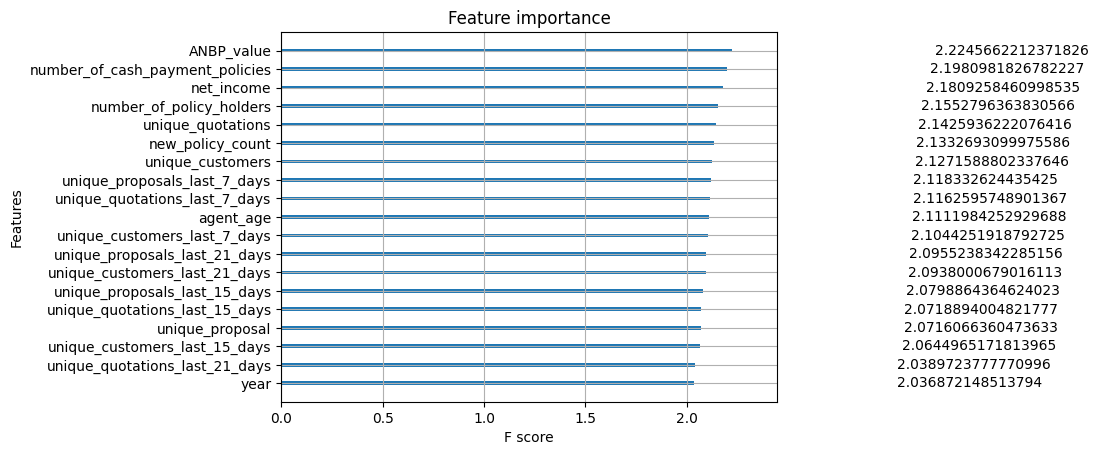

In [19]:


# Assuming your model is named xgb_model
xgb.plot_importance(final_model, importance_type='gain')  # or 'weight', 'cover'
plt.show()
